In [3]:
# tested with pytorch 1.4
import torchvision
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import torch.nn.functional as F
import time

use_gpu = True  # use GPU or not
latent_size = 48  # dimension of latent variable. Should be much smaller than the image size
learning_rate = 0.001
train_batch_size = 128   # size of traning batch
data_dir = '/tmp'
data_size = 28*28 # size of mnist image
encoder_hidden_size = latent_size*2
decoder_hidden_size = latent_size*2
max_epochs = 10
opt = 'adam'  # adam or rms

In [4]:
# Load mnist data
train_data = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(data_dir, train=True, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(
                             (0.1307,), (0.3081,))
                         ])),
                        batch_size=train_batch_size, shuffle=True)

In [5]:
class Encode(nn.Module):
    # Encode image to latent variable
    # The neural network actually learns the means and variance of normal distributions of the latent variable
    # One mean and one variance per component of latent variable.
    def __init__(self, data_size, latent_size, hidden_size):
        super(Encode, self).__init__()
        self.layer1 = nn.Linear(data_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)     
        self.layer3 = nn.Linear(hidden_size, 2*latent_size) # *2 for mean and variance
        
    def forward(self, image):
        # return mean and variance of latent variable
        x = self.layer1(image)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        z_mean, z_variance = x[:,0:latent_size], x[:,latent_size:2*latent_size]
        z_variance = F.softplus(z_variance)  # make sure it is non-negative because need to take log later
        return z_mean, z_variance        

In [6]:
class Decode(nn.Module):
    # Decode latent variable to image
    def __init__(self, data_size, latent_size, hidden_size):
        super(Decode, self).__init__()
        self.layer1 = nn.Linear(latent_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, data_size) 
        self.logBernouli = torch.nn.BCEWithLogitsLoss(reduction = 'none')
    
    def network(self, z):
        # neutral network with 3 layers
        x = self.layer1(z)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x
    
    def forward(self, z, image):
        # return log likelihood of generated image
        x = self.network(z)
        return -self.logBernouli(x, image) # negative sign due to definition of the function
    
    def generateImage(self, z):
        # Generate image from latent variable
        x = self.network(z)
        return F.sigmoid(x).detach().cpu().numpy() > 0.5

In [7]:
encode = Encode(data_size = data_size, 
                 latent_size = latent_size, 
                 hidden_size = encoder_hidden_size)

decode = Decode(data_size = data_size , 
                 latent_size = latent_size, 
                 hidden_size = decoder_hidden_size)

device = torch.device("cuda:0" if use_gpu else "cpu")
# set optimizer, pass network parameters to optimizer
encode.to(device)
decode.to(device)

if opt == 'adam':
    optimizer = torch.optim.Adam(list(encode.parameters()) + list(decode.parameters()), lr=learning_rate)
elif opt == 'rmsprop':
    optimizer = torch.optim.RMSprop(list(encode.parameters()) + list(decode.parameters()), lr=learning_rate, centered=True)
else:
    raise 'Unrecognized optimizer option %s'%opt


# Loop over epochs
i = 0
start_time = time.time()
print('%s:\t%s\t\t%s\t\t%s\t%s'%('epoch', 'reg', 'loglike', 'lowerBound','time(s)'))
for epoch in range(max_epochs):
    # Training
    reg_ep = 0
    loglike_ep = 0
    for images, label in train_data:
        
        # initialize
        encode.zero_grad()
        decode.zero_grad()
        images=images.reshape([-1, data_size])  # resize each image to a linear 784-element array
        images =(images > 0.5).float() # convert images to binary
        images = images.to(device)
        
        # encode and decode 
        z_mean, z_variance = encode(images)  # infer distribution of hidden variable
        z = z_mean + torch.randn(z_mean.shape, device=device)*torch.sqrt(z_variance) # reparameterization trick - generate z from distribution learned
        loglike = decode(z, images) # generate image from hidden variable, compare result
        
        # calculate loss
        reg = 0.5*(1.+ torch.log(z_variance ) - z_mean**2 -z_variance).sum(1).mean()  # regularization term
        loglike =loglike.sum(1).mean()  # log likelihood term
        lowerBound = loglike+ reg
        loss = -lowerBound  # maximize lower bound
        
        # backprop
        loss.backward()
        optimizer.step()
                        
        i = i + 1
        reg_ep += reg
        loglike_ep += loglike
    if epoch%1 == 0:
        print('%d:\t%1.2f\t%1.2f\t%1.2f\t%1.1f'%(epoch, reg_ep, loglike_ep, reg_ep+loglike_ep, time.time()-start_time))

epoch:	reg		loglike		lowerBound	time(s)
0:	-2774.46	-97733.72	-100508.18	19.7
1:	-6122.80	-68526.08	-74648.88	38.8
2:	-7472.78	-56353.11	-63825.89	57.9
3:	-7955.64	-50469.90	-58425.54	77.1
4:	-8417.51	-46295.67	-54713.18	96.2
5:	-8827.26	-43531.82	-52359.07	115.2
6:	-9182.98	-41435.73	-50618.71	133.8
7:	-9439.19	-39941.05	-49380.25	152.6
8:	-9610.46	-38876.42	-48486.88	172.0
9:	-9758.20	-38037.93	-47796.13	190.7


### Autoencoding and decoded image

In [8]:
numSamples = 10000

In [9]:
data = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(data_dir, train=True, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(
                             (0.1307,), (0.3081,))
                         ])),
                        batch_size=numSamples, shuffle=True)
images, labels = iter(data).next()
images=images.reshape([-1, data_size])  # resize each image to a linear 784-element array
images =(images > 0.5).float() # convert images to binary
images = images.to(device)

In [10]:
# generate hidden variables z
z_mean, z_variance = encode(images)  # infer distribution of hidden variable
z = z_mean + torch.randn(z_mean.shape, device=device)*torch.sqrt(z_variance)  # reparameterization trick - generate z from distribution learned

/home/wongc/anaconda3/envs/pytorch1.4/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


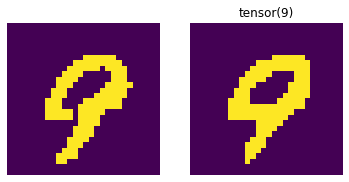

In [11]:
i = 20
fig, axs = plt.subplots(1, 2)
axs[0].imshow( images[i,:].reshape([28,28]).detach().cpu().numpy())
axs[1].imshow(decode.generateImage(z[i]).reshape([28, 28]))
axs[0].axis('off')
axs[1].axis('off')
plt.title(str(labels[i]) );

## generate more digits

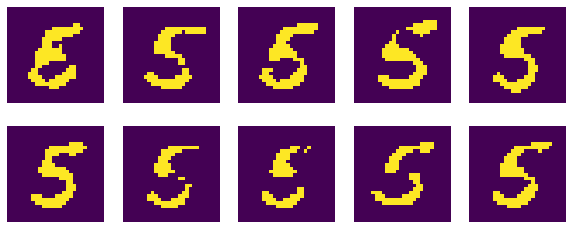

In [12]:
digit = 5
numSamples = 10
fig, axs = plt.subplots( int(numSamples/5), 5)
fig.set_figheight(4)
fig.set_figwidth(10)
z_digit_mean = z_mean[labels==digit]
z_digit_var = z_variance[labels==digit]
zz = z_digit_mean.mean(0) + torch.randn( (numSamples, z_digit_mean.shape[1]), device=device)*torch.sqrt(z_digit_var.mean(0))
for i in range(numSamples):
    img = decode.generateImage(zz[i]).reshape([28, 28])
    axs[int(i/5), int(i%5) ].imshow(img)
    axs[int(i/5), int(i%5) ].axis('off')

## Average and mixed digit

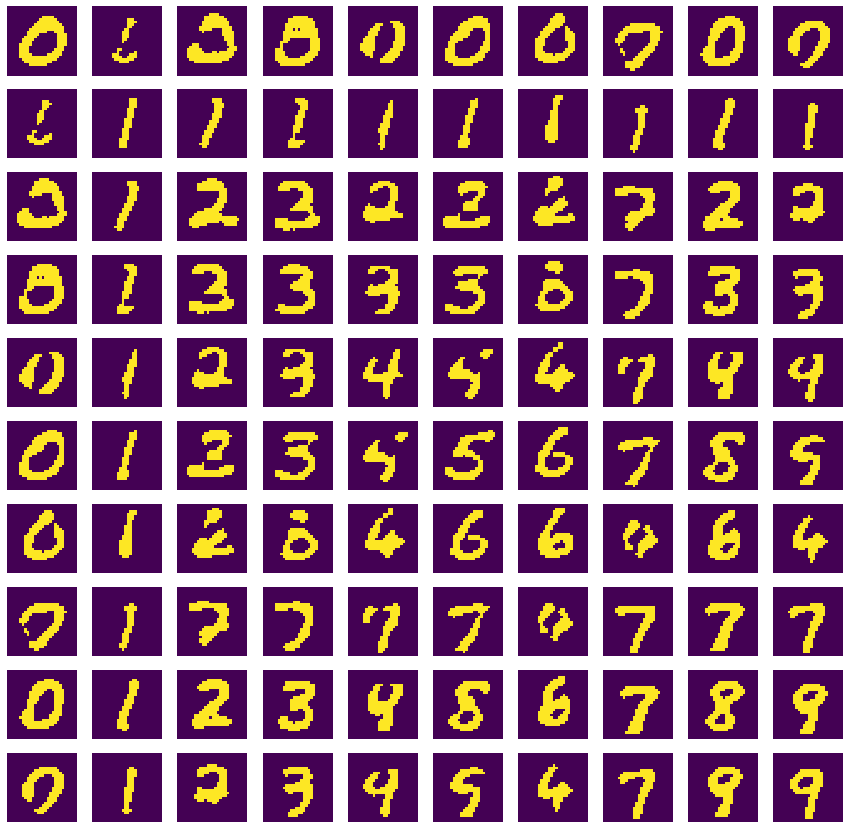

In [13]:
fig, axs = plt.subplots(10, 10)
fig.set_figheight(15)
fig.set_figwidth(15)
for digit1 in range(0, 10):
    for digit2 in range(0, 10):

        z1_average = z[labels == digit1].mean(0)
        z2_average = z[labels == digit2].mean(0)
        img = decode.generateImage(z1_average + z2_average).reshape([28,28])
        axs[digit1, digit2].imshow( img)
        axs[digit1, digit2].axis('off')
        #plt.title(str(digit1) + str(digit2) )

## Digit interpolation

/home/wongc/anaconda3/envs/pytorch1.4/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


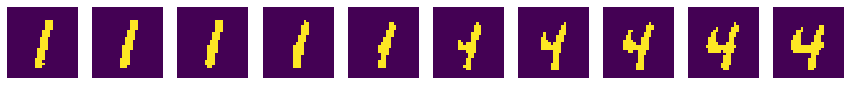

In [14]:
# interploation
digit1 = 1
digit2 = 4
fig, axs = plt.subplots(1, 10)
fig.set_figheight(1.5)
fig.set_figwidth(15)
z1_average = z[labels == digit1].mean(0).detach().cpu()
z2_average = z[labels == digit2].mean(0).detach().cpu()
from scipy.interpolate import interp1d
linfit = interp1d([0,9], np.vstack([z1_average, z2_average]), axis=0)

for i in range(10):
    z_int = torch.tensor(linfit(i))
    z_int = z_int.to(device) #.reshape([1, len(z_int)])
    z_int = z_int.float()
    img = decode.generateImage(z_int ).reshape([28,28])
    axs[i].imshow( img)
    axs[i].axis('off')

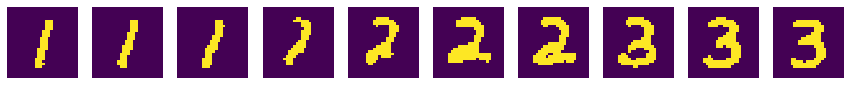

In [15]:
# interploation
digit1 = 1
digit2 = 2
digit3 = 3
fig, axs = plt.subplots(1, 10)
fig.set_figheight(1.5)
fig.set_figwidth(15)
z1_average = z[labels == digit1].mean(0).detach().cpu()
z2_average = z[labels == digit2].mean(0).detach().cpu()
z3_average = z[labels == digit3].mean(0).detach().cpu()
from scipy.interpolate import interp1d
linfit = interp1d([0,5,9], np.vstack([z1_average, z2_average, z3_average]), axis=0)

for i in range(10):
    z_int = torch.tensor(linfit(i))
    z_int = z_int.to(device) #.reshape([1, len(z_int)])
    z_int = z_int.float()
    img = decode.generateImage(z_int ).reshape([28,28])
    axs[i].imshow( img)
    axs[i].axis('off')

### Visualize latten variable

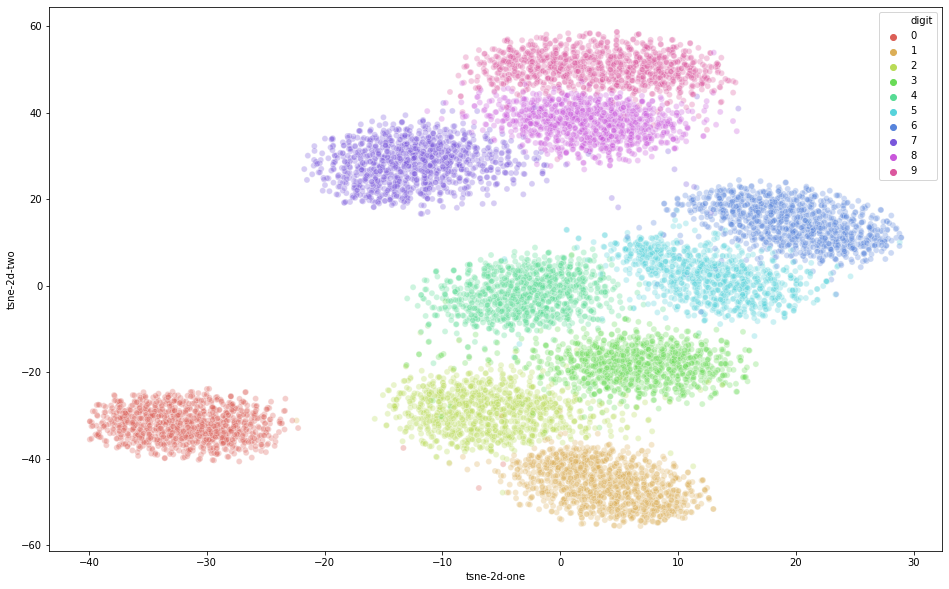

In [16]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
feat_cols = [ 'z'+str(i) for i in range(z.shape[1]) ]
df = pd.DataFrame(np.array(z.detach().cpu()) ,columns=feat_cols)
df['digit'] = labels
df['label'] = df['digit'].apply(lambda i: str(i))
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(df)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="digit",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)